In [34]:

# importar las bibliotecas necesarias
from scipy.optimize import minimize
from matplotlib import pyplot as plt
import pandas as pd
import warnings
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from feature_engine.imputation import RandomSampleImputer
warnings.filterwarnings("ignore")

In [35]:
# Cargar el archivo CSV
df = pd.read_csv("files/dist.data")
df

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,y
0,15.310142,NaN,8.436759,3.723421,Dec,NaN,1.319733,21.408846
1,11.841750,1.558534,-4.776643,4.304625,Dec,MB,7.129585,0.273072
2,4.343978,NaN,NaN,4.540588,NaN,MM,NaN,19.010811
3,NaN,2.428672,9.003936,4.456992,NaN,MA,NaN,13.564040
4,14.892188,NaN,8.468824,1.070600,NaN,B,3.369261,25.493163
...,...,...,...,...,...,...,...,...
523,10.844312,NaN,1.653327,4.249280,Dec,MM,NaN,7.833448
524,12.346405,NaN,1.041838,3.406081,Dec,MB,NaN,10.452970
525,1.496831,3.115300,9.288658,4.547431,App,MM,NaN,9.310863
526,NaN,NaN,12.267643,2.867885,App,MA,-1.471284,27.283751


## Del DataFrame inferimos:
Numéricas: x_1, x_2, x_3, x_4, x_7
Categóricas: x_5, x_6

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528 entries, 0 to 527
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x_1     484 non-null    float64
 1   x_2     265 non-null    float64
 2   x_3     464 non-null    float64
 3   x_4     507 non-null    float64
 4   x_5     377 non-null    object 
 5   x_6     358 non-null    object 
 6   x_7     155 non-null    float64
 7   y       518 non-null    float64
dtypes: float64(6), object(2)
memory usage: 33.1+ KB


## Si los datos faltantes superan el 60% de los datos por columna, elimine esa columna.

In [37]:
df.isna().sum()/len(df) * 100

x_1     8.333333
x_2    49.810606
x_3    12.121212
x_4     3.977273
x_5    28.598485
x_6    32.196970
x_7    70.643939
y       1.893939
dtype: float64

### Se elimina la columna x_7 según el criterio establecido

In [38]:
df_clean_1 = df.drop(['x_7'], axis=1)
df_clean_1

,x_1,x_2,x_3,x_4,x_5,x_6,y
0,15.310142,NaN,8.436759,3.723421,Dec,NaN,21.408846
1,11.841750,1.558534,-4.776643,4.304625,Dec,MB,0.273072
2,4.343978,NaN,NaN,4.540588,NaN,MM,19.010811
3,NaN,2.428672,9.003936,4.456992,NaN,MA,13.564040
4,14.892188,NaN,8.468824,1.070600,NaN,B,25.493163
...,...,...,...,...,...,...,...
523,10.844312,NaN,1.653327,4.249280,Dec,MM,7.833448
524,12.346405,NaN,1.041838,3.406081,Dec,MB,10.452970
525,1.496831,3.115300,9.288658,4.547431,App,MM,9.310863
526,NaN,NaN,12.267643,2.867885,App,MA,27.283751


## Sustituya el resto de los datos faltantes:
- Si la variable es categórica sustituya por la moda.
- Si la variable presenta distribución uniforme, sustituya de forma aleatoria (considere como distribución uniforme curtosis menor a -1.2).
- Si la variable presenta una distribución diferente a la uniforme:
  - Sustituya por la media aritmética si presenta un sesgo positivo.
  - Sustituya por la mediana si presenta un sesgo negativo.

# De forma gráfica esto es:
![Cómo enfrentar valores atípicos](files\map_missing_fields.png "Cómo enfrentar valores atípicos")

Al revisar el Histograma se puede inferir las variables con distribución uniforme o normal. Esto se comprueba con la Kurtosis más adelante. 

array([[<AxesSubplot: title={'center': 'x_1'}>,
        <AxesSubplot: title={'center': 'x_2'}>],
       [<AxesSubplot: title={'center': 'x_3'}>,
        <AxesSubplot: title={'center': 'x_4'}>],
       [<AxesSubplot: title={'center': 'y'}>, <AxesSubplot: >]],
      dtype=object)

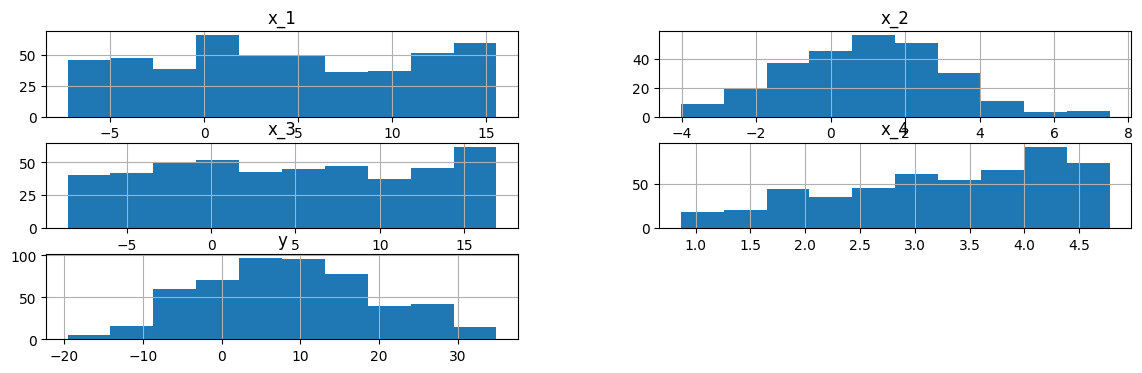

In [39]:
df_clean_1.hist()

In [40]:
# - Si la variable presenta distribución uniforme, sustituya de forma aleatoria (considere como distribución uniforme curtosis menor a -1.2).
# Revisamos si la kurtosis es menor que -1.2 para decidir qué variables tienen distribuión uniforme (A parte del método gráfico)
df_clean_1.kurt() < -1.2

x_1     True
x_2    False
x_3     True
x_4    False
y      False
dtype: bool

In [41]:
# Con la función skew podemos checar si el sesgo es postivo o negativo
# - Si la variable presenta una distribución diferente a la uniforme (x_2, x_4, y):
# -- Sustituya por la media aritmética si presenta un sesgo positivo.
# -- Sustituya por la mediana si presenta un sesgo negativo.
df_clean_1.skew()

x_1    0.045977
x_2    0.196266
x_3    0.012478
x_4   -0.478714
y      0.130844
dtype: float64

In [42]:
# Por último, revisamos la moda con interés en lo que las variable categoricas presenten (x_5 y x_6)
df.mode()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,y
0,-7.257996,-4.021420,-8.517502,0.864990,Dec,MB,-4.991931,-19.597192
1,-7.214964,-3.545163,-8.484215,0.883673,NaN,NaN,-4.715692,-18.608809
2,-7.170369,-3.270399,-8.458140,0.892652,NaN,NaN,-4.561261,-18.333302
3,-7.057121,-3.216876,-8.235309,0.903893,NaN,NaN,-4.291850,-16.644857
4,-7.039066,-3.004323,-8.234055,0.910805,NaN,NaN,-4.166896,-14.280623
...,...,...,...,...,...,...,...,...
513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.848658
514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.761316
515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.128614
516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.611309


Del DataFrame anterior se concluye que la moda para x_5 es Dec y para x_6 es MB

## Sustitución de valores faltantes

In [43]:
df_test = df_clean_1.copy()
# Antes de comenzar, veamos que para acceder al dataframe de una columna, se necesita doble square, porque con un square el objeto es de tipo Series
print(type(df_test['x_1']))
print(type(df_test[['x_1']]))

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


In [44]:
# DF sin sustitución
df_test.isna().sum()

x_1     44
x_2    263
x_3     64
x_4     21
x_5    151
x_6    170
y       10
dtype: int64

In [45]:
def impute_df(df, column_name, strategy):
    if (strategy == 'random'):
        df[[column_name]] = RandomSampleImputer().fit_transform(df[[column_name]])
    else:
        df[[column_name]] = SimpleImputer(strategy=strategy).fit_transform(df_test[[column_name]])

In [46]:

# Del df inferimos:
# Numéricas: x_1, x_2, x_3, x_4, x_7
# Categóricas: x_5, x_6
# X_1 Dist Uniforme. Sustituir aleatoria
impute_df(df_test, 'x_1', 'random')
# X_2 Sesgo positivo. Media Aritmética
impute_df(df_test, 'x_2', 'mean')
# x_3 Dist Uniforme. Sustituir aleatoria
impute_df(df_test, 'x_3', 'random')
# X_4 Sesgo negativo. Sustituir por mediana.
impute_df(df_test, 'x_4', 'median')
# x_5 categorica. Sustituir por moda
impute_df(df_test, 'x_5', 'most_frequent')
# x_6 categorica. Sustituir por moda
impute_df(df_test, 'x_6', 'most_frequent')
# y Sesgo positivo. Media Aritmética
impute_df(df_test, 'y', 'mean')

### Para asegurarnos de que no existe ningún valor faltante, se ejecuta:

In [47]:

df_clean_1 = df_test.copy()
df_clean_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528 entries, 0 to 527
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x_1     528 non-null    float64
 1   x_2     528 non-null    float64
 2   x_3     528 non-null    float64
 3   x_4     528 non-null    float64
 4   x_5     528 non-null    object 
 5   x_6     528 non-null    object 
 6   y       528 non-null    float64
dtypes: float64(5), object(2)
memory usage: 29.0+ KB


In [48]:
df_clean_1

,x_1,x_2,x_3,x_4,x_5,x_6,y
0,15.310142,0.951598,8.436759,3.723421,Dec,MB,21.408846
1,11.841750,1.558534,-4.776643,4.304625,Dec,MB,0.273072
2,4.343978,0.951598,-6.053870,4.540588,Dec,MM,19.010811
3,-0.182200,2.428672,9.003936,4.456992,Dec,MA,13.564040
4,14.892188,0.951598,8.468824,1.070600,Dec,B,25.493163
...,...,...,...,...,...,...,...
523,10.844312,0.951598,1.653327,4.249280,Dec,MM,7.833448
524,12.346405,0.951598,1.041838,3.406081,Dec,MB,10.452970
525,1.496831,3.115300,9.288658,4.547431,App,MM,9.310863
526,0.709666,0.951598,12.267643,2.867885,App,MA,27.283751


## Regresión Lineal

In [49]:
lr = LinearRegression()

In [50]:
# df_clean_1['x_4_square'] = df_clean_1['x_4']**2
x = df_clean_1[['x_1','x_3','x_4']]
y = df_clean_1[['y']]
x , y


(           x_1        x_3       x_4
 0    15.310142   8.436759  3.723421
 1    11.841750  -4.776643  4.304625
 2     4.343978  -6.053870  4.540588
 3    -0.182200   9.003936  4.456992
 4    14.892188   8.468824  1.070600
 ..         ...        ...       ...
 523  10.844312   1.653327  4.249280
 524  12.346405   1.041838  3.406081
 525   1.496831   9.288658  4.547431
 526   0.709666  12.267643  2.867885
 527   4.694991   0.644289  2.128851
 
 [528 rows x 3 columns],
              y
 0    21.408846
 1     0.273072
 2    19.010811
 3    13.564040
 4    25.493163
 ..         ...
 523   7.833448
 524  10.452970
 525   9.310863
 526  27.283751
 527   6.373201
 
 [528 rows x 1 columns])

In [51]:
lr.fit(x,y)
score = lr.score(x,y)

In [52]:
print(f"Score: {score}. Coeficiente:{lr.coef_}. Intercepto:{lr.intercept_}")

Score: 0.768736178684696. Coeficiente:[[ 0.68023647  1.10940326 -2.12374451]]. Intercepto:[7.70104035]


In [53]:
def fun(a,x,x1,x2,y):
    f=a[0]+a[1]*x+a[2]*x1+a[3]*x2**2
    return np.mean((f-y)**2)
a0 = np.random.rand(4)
sol = minimize(fun, a0, args=(x.x_1, x.x_3, x.x_4, y.y))
sol

      fun: 27.52321202089223
 hess_inv: array([[ 2.70266538e+00, -5.39065286e-02, -3.85223564e-02,
        -1.53579998e-01],
       [-5.39065286e-02,  1.12129643e-02,  2.40521539e-05,
         5.86484562e-04],
       [-3.85223564e-02,  2.40521539e-05,  9.24051426e-03,
        -3.15104713e-04],
       [-1.53579998e-01,  5.86484562e-04, -3.15104713e-04,
         1.30033697e-02]])
      jac: array([ 2.38418579e-07, -9.53674316e-07,  9.53674316e-07, -2.38418579e-06])
  message: 'Optimization terminated successfully.'
     nfev: 65
      nit: 10
     njev: 13
   status: 0
  success: True
        x: array([ 4.81688614,  0.68013179,  1.10792632, -0.34596286])

# La ecuación encontrada es: 
$$
\begin{align}
x = 4.0248 + 0.7083x_1 + 1.0844x_3 - 0.36x_4^2\\
mse = 26.934870612859484 && \text{Error Cuadrático medio} \\
\end{align}
$$

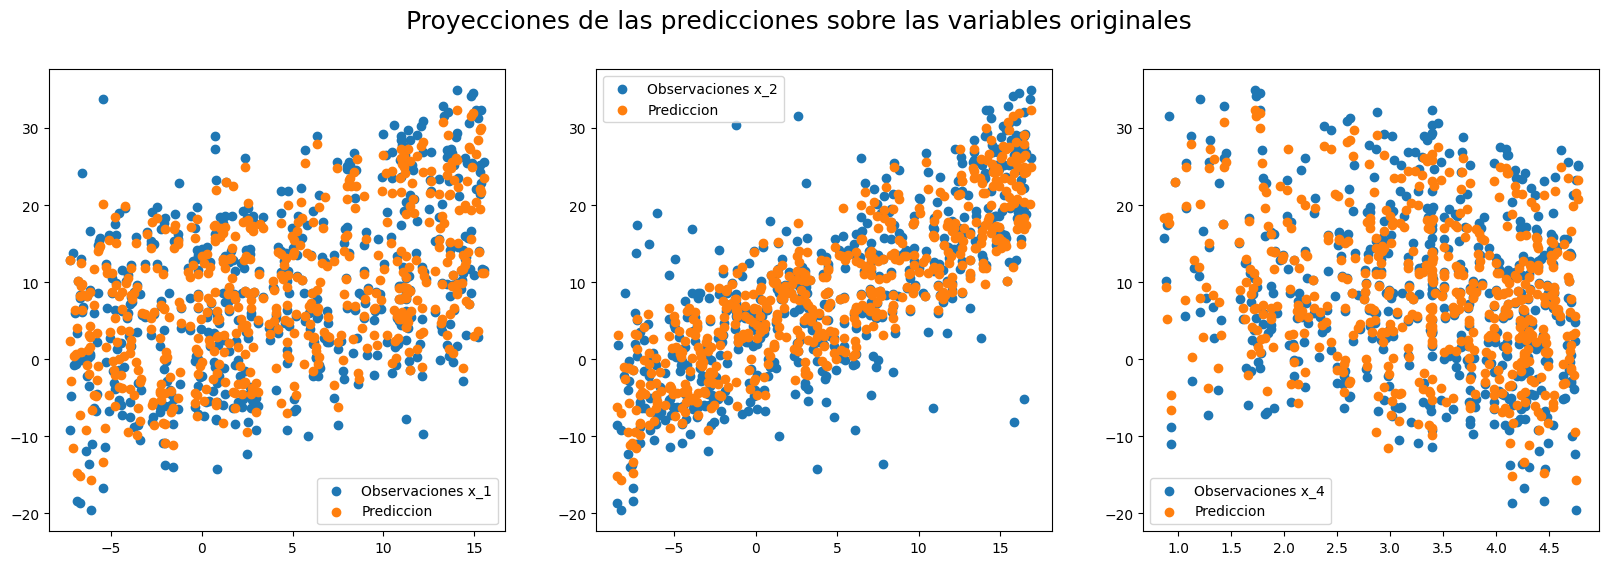

In [56]:
fig, axs = plt.subplots(1,3,figsize=(20, 6))
prediction = lr.predict(x)
axs[0].scatter(x.x_1,y.y,label = 'Observaciones x_1')
axs[0].scatter(x.x_1,prediction,label = 'Prediccion')
axs[0].legend()

#axs[0].plt.grid()
axs[1].scatter(x.x_3,y.y,label = 'Observaciones x_2')
axs[1].scatter(x.x_3,prediction,label = 'Prediccion')
axs[1].legend()


axs[2].scatter(x.x_4,y.y,label = 'Observaciones x_4')
axs[2].scatter(x.x_4,prediction,label = 'Prediccion')
axs[2].legend()

fig.suptitle(' Proyecciones de las predicciones sobre las variables originales ', fontsize=18)

plt.show()